Установка необходимых библиотек

In [ ]:
!pip install python-dotenv==0.19.0 tqdm==4.62.2 numpy Pillow==7.0.0 matplotlib==3.4.3 opencv-python==4.6.0.66 opencv-python-headless==4.6.0.66 matplotlib
!pip install scikit-learn==0.24.2 torch==1.12.1 torchvision==0.13.1 pytorch-ignite segmentation-models-pytorch==0.2.0 albumentations==1.0.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!curl -o ~/plan-dataset.zip "https://lodmedia.hb.bizmrg.com/cases/868821/masterclass.zip"
!unzip ~/plan-dataset.zip -d ~/train

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.3M  100 22.3M    0     0   631k      0  0:00:36  0:00:36 --:--:--  645k
Archive:  /root/plan-dataset.zip
   creating: /root/train/object_detection/
  inflating: /root/train/object_detection/09f87310-ba17-4e30-98b1-dd02d48ed805.json  
  inflating: /root/train/object_detection/7b533338-17ad-45c6-8cdf-b716f7669226.json  
  inflating: /root/train/object_detection/6dd39e76-7f4f-46aa-86dd-457dc94823b6.json  
  inflating: /root/train/object_detection/4646d4d5-c50c-43b1-881f-db96555977f2.json  
  inflating: /root/train/object_detection/bc2894fa-1e4c-4eed-a573-d1c46cf819b5.json  
  inflating: /root/train/object_detection/4e3d768c-6e73-433e-b2ae-a3eddf698b5d.json  
  inflating: /root/train/object_detection/891d4884-7c1c-4ec9-a9d8-16184fb8140e.json  
  inflating: /root/train/object_detection/744f177d-3bf9-4829-b208-4e3fcd86c9c2.json  

In [ ]:
## Импорт необходимых библиотек
import torch
import torch.nn as nn

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, Metric
from ignite.engine import _prepare_batch

from tqdm import tqdm

import json
import base64
import os
import glob
import numpy as np
import cv2

from PIL import Image
import segmentation_models_pytorch as smp

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from typing import Callable, Tuple, Dict, Any, List, Sequence, Iterator, Optional
from collections import defaultdict
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn, FastRCNNPredictor

Код для обучения нейросети - сегментация 

In [ ]:


## PLRC DATASET - класс и необходимые функции для датасета


def get_color_map():
    return {
        "wall": 255,
        "window": 255
    }


def tensor_from_rgb_image(image: np.ndarray) -> torch.Tensor:
    image = np.moveaxis(image, -1, 0)
    image = np.ascontiguousarray(image)
    image = torch.from_numpy(image)
    return image


def tensor_from_mask_image(mask: np.ndarray) -> torch.Tensor:
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, -1)
    return tensor_from_rgb_image(mask)


class PLRCDataset(Dataset):
    def __init__(self, image_folder, transform, start_index, end_index, mask_folder=None):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform

        self.images = PLRCDataset.parse_folder(self.image_folder, start_index, end_index)
        self.color_map = get_color_map()

    @staticmethod
    def parse_folder(path, start, end):
        if path is None:
            return []
        images = glob.glob1(path,  '*.png')
        images.sort()

        return images[start:end]

    @staticmethod
    def load_image(path) -> np.array:
        return cv2.imread(path, 0)

    @staticmethod
    def load_mask(path) -> np.array:
        return cv2.imread(path, 0)

    @staticmethod
    def split_grayscale_mask_into_channels_by_color_map(mask, color_map) -> torch.Tensor:
        masks = []

        for i in color_map.values():
            masks.append(mask == i)

        return torch.cat(masks).float()

    def mask_to_grayscale(self, masks) -> np.ndarray:
        masks = masks.cpu().numpy()

        colors_by_index = list(self.color_map.values())
        img = np.zeros(masks.shape[1:], dtype=np.uint8)

        for i in range(len(masks)):
            img[masks[i] == 1] = colors_by_index[i]

        return img

    def __getitem__(self, index):
        image_name = self.images[index]
        image_path = os.path.join(self.image_folder, image_name)

        image = PLRCDataset.load_image(image_path)

        if self.mask_folder is None:
            # sample = self.transform(image=image)
            # image = sample['image']
            return image_name, tensor_from_mask_image(image).float() / 255.0

        mask_path = os.path.join(self.mask_folder, image_name)
        mask = PLRCDataset.load_mask(mask_path)

        # sample = self.transform(image=image, mask=mask)
        # image, mask = sample['image'], sample['mask']

        image = tensor_from_mask_image(image)
        image = torch.cat([image, image, image])
        mask = tensor_from_mask_image(mask)

        mask = PLRCDataset.split_grayscale_mask_into_channels_by_color_map(mask, self.color_map)

        return image.float() / 255.0, mask

    def __len__(self):
        return len(self.images)


## PLRC UTILS = утилиты для подсчета


def get_training_augmentation():
    return A.Compose([
        # A.RandomCrop(height=256, width=256, p=1),
        A.Normalize(mean=(0.5,), std=(0.5,)),
    ], p=1)


def get_test_augmentation():
    return A.Compose([
        A.Normalize(mean=(0.5,), std=(0.5,)),
    ], p=1)


def get_data_loader(path, batch_size, n_processes, start_index, end_index, shuffle=True):
    image_path = os.path.join(path, 'image')
    mask_path = os.path.join(path, 'mask')

    dataset = PLRCDataset(image_folder=image_path, mask_folder=mask_path, transform=get_training_augmentation(), start_index=start_index, end_index=end_index)

    return DataLoader(dataset=dataset, batch_size=batch_size, drop_last=True, num_workers=n_processes, shuffle=shuffle)


def get_train_validation_data_loaders(path, batch_size, n_processes, train_split):
    files_count = len(os.listdir(os.path.join(path, 'image')))

    train_dl = get_data_loader(path, batch_size, n_processes, shuffle=True, start_index=0, end_index=int(files_count*train_split))
    test_dl = get_data_loader(path, batch_size, n_processes, shuffle=False, start_index=int(files_count*train_split), end_index=100)

    return train_dl, test_dl


## DATA LOSS - функции для подсчета метрик качества обучения нейросетей

class BCESoftDiceLoss:
    def __init__(self, dice_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight

    @staticmethod
    def soft_dice(predict, target):
        eps = 1e-15
        batch_size = target.size()[0]

        dice_target = (target == 1).float().view(batch_size, -1)
        dice_predict = torch.sigmoid(predict).view(batch_size, -1)

        inter = torch.sum(dice_predict * dice_target) / batch_size
        union = (torch.sum(dice_predict) + torch.sum(dice_target)) / batch_size + eps

        return (2 * inter.float() + eps) / union.float()

    def __call__(self, predict, target):
        loss = (1.0 - self.dice_weight) * self.nll_loss(predict, target)

        if self.dice_weight:
            loss -= self.dice_weight * torch.log(BCESoftDiceLoss.soft_dice(predict, target))

        return loss


class MultiClassBCESoftDiceLoss:
    def __init__(self, dice_weight=0):
        self.bce_soft_dice = BCESoftDiceLoss(dice_weight)

    def __call__(self, predict, target):
        classes = target.shape[1]
        loss = predict.new_zeros(1)

        for i in range(classes):
            loss += self.bce_soft_dice(predict[:, i].unsqueeze(1), target[:, i].unsqueeze(1))

        return loss[0] / float(classes)


class MultiClassSoftDiceMetric(Metric):
    def __init__(self):
        super(MultiClassSoftDiceMetric, self).__init__()
        self.general_loss = 0

    def reset(self):
        self.general_loss = 0

    def update(self, output):
        predict, target = output

        classes = target.shape[1]
        loss = predict.new_zeros(1)

        for i in range(classes):
            loss += BCESoftDiceLoss.soft_dice(predict[:, i].unsqueeze(1), target[:, i].unsqueeze(1))

        self.general_loss = loss[0] / float(classes)

    def compute(self):
        return self.general_loss



## Функции для обучения

def load_trained_model(model, optimizer, model_path, optimizer_path):
    model.load_state_dict(torch.load(model_path))
    optimizer.load_state_dict(torch.load(optimizer_path))
    print('Load model from: ', model_path)
    print('Load optimizer from: ', optimizer_path)


def save_model(model, optimizer, model_path, optimizer_path, postfix='_'):
    torch.save(model.state_dict(), model_path + postfix)
    torch.save(optimizer.state_dict(), optimizer_path + postfix)


def log_image(image, prefix, epoch, step):
    img = Image.fromarray(image)
    image_name = "%s_%s_%s.png" % (epoch, step, prefix)
    img.save(image_name)

    os.remove(image_name)


def run_test_model(model, evaluate_loader, epoch, device, step=10):
    model.eval()
    count_step = 0

    for idx, batch in enumerate(evaluate_loader):
        if count_step > step:
            break

        x, y = _prepare_batch(batch, device)

        predict = model(x)
        predict = torch.sigmoid(predict) > 0.2

        count_step += len(x)

    model.train()


def run_train(dataset_path, batch_size, n_processes, model_path, optimizer_path, load_pre_model=False,
              device='cpu', lr=0.0001, betas=(0.9, 0.99), weight_decay=0.0004, epochs=10,
              log_interval=20, save_interval=2, train_split=0.7):

    train_loader, evaluate_loader = get_train_validation_data_loaders(path=dataset_path, batch_size=batch_size,
                                                                      n_processes=n_processes, train_split=train_split)
    model = smp.FPN('resnet50', classes=24)

    if device.startswith('cuda'):
        if not torch.cuda.is_available():
            raise ValueError('CUDA is not available')

        model = model.to(device)
        print('CUDA is used')

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)

    if load_pre_model:
        load_trained_model(model, optimizer, model_path, optimizer_path)

    trainer = create_supervised_trainer(model, optimizer, MultiClassBCESoftDiceLoss(0.7), device=device)
    evaluator = create_supervised_evaluator(model,
                                            metrics={'dice': MultiClassSoftDiceMetric(),
                                                     'nll': Loss(MultiClassBCESoftDiceLoss(0.7))},
                                            device=device)

    desc = "ITERATION - loss: {:.2f}"
    pbar = None

    @trainer.on(Events.EPOCH_STARTED)
    def create_pbar(engine):
        model.train()
        nonlocal pbar
        pbar = tqdm(
            initial=0, leave=False, total=len(train_loader),
            desc=desc.format(0)
        )

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(engine):
        pbar.close()
        evaluator.run(evaluate_loader)
        metrics = evaluator.state.metrics
        avg_dice = metrics['dice']
        avg_nll = metrics['nll']


        print("Training Results - Epoch: {}  Dice: {:.2f} Avg loss: {:.2f}"
              .format(engine.state.epoch, avg_dice, avg_nll))

        if engine.state.epoch % save_interval == 0:
            save_model(model, optimizer, model_path, optimizer_path, '_' + str(engine.state.epoch))
            run_test_model(model, evaluate_loader, engine.state.epoch, device)

    @trainer.on(Events.ITERATION_COMPLETED)
    def log_training_loss(engine):

        pbar.desc = desc.format(engine.state.output)
        pbar.update()


    model.train()

    trainer.run(train_loader, max_epochs=epochs)

run_train(dataset_path=f"{os.environ['HOME']}/train/wall", batch_size=1, n_processes=0,
          model_path='./model',
          optimizer_path='./opt', device='cpu', epochs=2,
          load_pre_model=False)

Training Results - Epoch: 1  Dice: 0.78 Avg loss: 0.39


Training Results - Epoch: 2  Dice: 0.85 Avg loss: 0.31


Код для получения данных с сегментации

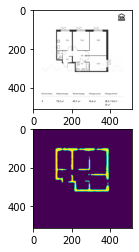

In [ ]:
import matplotlib.pyplot as plt

## Необходимые вспомогательные функции
def get_test_augmentation():
    return A.Compose([
        A.Normalize(mean=(0.5,), std=(0.5,)),
    ], p=1)

def mask_to_grayscale(masks) -> np.ndarray:
    masks = masks.cpu().numpy()

    img = np.zeros(masks.shape[1:], dtype=np.uint8)

    img[masks[0] == 1] = 255

    return img

def tensor_from_rgb_image(image: np.ndarray) -> torch.Tensor:
    image = np.moveaxis(image, -1, 0)
    image = np.ascontiguousarray(image)
    image = torch.from_numpy(image)
    return image

def convert_image(img):
    if img is None:
        return
    height, width, channels = img.shape
    rect = (0, 0, 512, 512)
    h = rect[3]
    w = int(h * width / height)
    if w > rect[2]:
        w = rect[2]
        h = int(height / width * w)
    new_img = cv2.resize(img, (w, h), interpolation=cv2.INTER_AREA)
    s = np.full((rect[3], rect[2], 3), np.uint8(255))
    sy = int((rect[3] - h) / 2)
    sx = int((rect[2] - w) / 2)
    s[sy:sy + h, sx:sx + w] = new_img
    return s

## Загрузка модели
model = smp.FPN(encoder_name='resnet50', classes=24)
model.load_state_dict(torch.load("./model_2", map_location=torch.device('cpu')))
model.eval()

##Загрузка тестового изображения
image = cv2.imread(f"{os.environ['HOME']}/train/test.png")
converted_image = convert_image(image)
## Вывод исходного изображения
plt.subplot(211)
im1 = plt.imshow(converted_image)

## Применение сегментации
transform = get_test_augmentation()
image = transform(image=converted_image)['image']

image = tensor_from_rgb_image(image)
image = image.view((1, 3, image.shape[1], image.shape[2]))
with torch.no_grad():
    predict = model(image)
predict = torch.sigmoid(predict) > 0.2
res = mask_to_grayscale(predict[0])

## Вывод результирующего изображения
plt.subplot(212)
im1 = plt.imshow(res)


Объявляем класс, используемый для обучения

In [ ]:
class DetectionTrainer:

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                 device: str, metric_functions: List[Tuple[str, Callable]] = [],
                 callbacks: List[Callable[[nn.Module, int], None]] = [], epoch_number: int = 0):
        self.model = model
        self.optimizer = optimizer

        self.device = device

        self.metric_functions = metric_functions
        self.callbacks = callbacks

        self.epoch_number = epoch_number

    @torch.no_grad()
    def evaluate_batch(self, val_iterator: Iterator, eval_on_n_batches: int) -> Optional[Dict[str, float]]:
        predictions = []
        targets = []

        for real_batch_number in range(eval_on_n_batches):
            try:
                xs, ys = next(val_iterator)

                xs = torch.tensor(xs, device=self.device)
                ys = [{key: torch.tensor(y[key], device=self.device) for key in y} for y in ys]
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.model.eval()(xs)

            for y_pred, y_true in zip(ys_pred, ys):
                predictions.append({key: y_pred[key].cpu().numpy() for key in y_pred})
                targets.append({key: y_true[key].cpu().numpy() for key in y_true})

        metrics = {}

        predictions_tensor = []
        targets_tensor = []

        for y_pred, y_true in zip(predictions, targets):
            predictions_tensor.append({key: torch.tensor(y_pred[key], device=self.device) for key in y_pred})
            targets_tensor.append({key: torch.tensor(y_true[key], device=self.device) for key in y_true})

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics

    @torch.no_grad()
    def evaluate(self, val_loader: DataLoader, eval_on_n_batches: int = 1) -> Dict[str, float]:
        metrics_sum = defaultdict(float)
        num_batches = 0

        val_iterator = iter(val_loader)

        while True:
            batch_metrics = self.evaluate_batch(val_iterator, eval_on_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit_batch(self, train_iterator: Iterator, update_every_n_batches: int) -> Optional[Dict[str, float]]:
        self.optimizer.zero_grad()

        predictions = []
        targets = []

        for real_batch_number in range(update_every_n_batches):
            try:
                xs, ys = next(train_iterator)
                xs = torch.tensor(xs, device=self.device)
                ys = [{key: torch.tensor(y[key], device=self.device) for key in y} for y in ys]
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            loss = sum(self.model.train()(xs, ys).values())

            (loss / update_every_n_batches).backward()

            with torch.no_grad():
                ys_pred = self.model.eval()(xs)

                for y_pred, y_true in zip(ys_pred, ys):
                    predictions.append({key: y_pred[key].cpu().numpy() for key in y_pred})
                    targets.append({key: y_true[key].cpu().numpy() for key in y_true})

        self.optimizer.step()

        metrics = {}

        predictions_tensor = []
        targets_tensor = []

        for y_pred, y_true in zip(predictions, targets):
            predictions_tensor.append({key: torch.tensor(y_pred[key], device=self.device) for key in y_pred})
            targets_tensor.append({key: torch.tensor(y_true[key], device=self.device) for key in y_true})

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics

    def fit_epoch(self, train_loader: DataLoader, update_every_n_batches: int = 1) -> Dict[str, float]:
        metrics_sum = defaultdict(float)
        num_batches = 0

        train_iterator = iter(train_loader)

        while True:
            batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit(self, train_loader: DataLoader, num_epochs: int,
            val_loader: DataLoader = None, update_every_n_batches: int = 1
            ) -> Dict[str, np.ndarray]:
        summary = defaultdict(list)

        def save_metrics(metrics: Dict[str, float], postfix: str = '') -> None:
            nonlocal summary, self

            for metric in metrics:
                metric_name, metric_value = f'{metric}{postfix}', metrics[metric]

                summary[metric_name].append(metric_value)

                print(f"{metric_name}: {metric_value}, Epoch: {self.epoch_number}")

        for _ in tqdm(range(num_epochs - self.epoch_number), initial=self.epoch_number, total=num_epochs):
            self.epoch_number += 1

            train_metrics = self.fit_epoch(train_loader, update_every_n_batches)

            with torch.no_grad():
                save_metrics(train_metrics, postfix='_train')

                if val_loader is not None:
                    test_metrics = self.evaluate(val_loader)
                    save_metrics(test_metrics, postfix='_test')

                with torch.no_grad():
                    for callback in self.callbacks:
                        callback(self.model, self.epoch_number)

        summary = {metric: np.array(summary[metric]) for metric in summary}

        return summary

Инициализация модели обучения и функций для подсчета метрик качества обучения нейросетей

In [ ]:
def initialize_model(num_classes: int,
                     min_size: int, max_size: int,
                     image_mean: Sequence[float], image_std: Sequence[float],
                     device: str = None) -> torch.nn.Module:
    pretrained_model = fasterrcnn_resnet50_fpn(pretrained=False, min_size=min_size, max_size=max_size,
                                               image_mean=image_mean, image_std=image_std)
    num_predictor_features = pretrained_model.roi_heads.box_head.fc7.out_features
    pretrained_model.roi_heads.box_predictor = FastRCNNPredictor(num_predictor_features, num_classes)

    return pretrained_model.to(device)


def compute_iou(box1: torch.tensor, box2: torch.tensor) -> torch.tensor:
    x1 = max(box1[0], box2[0])
    x2 = min(box1[2], box2[2])
    y1 = max(box1[1], box2[1])
    y2 = min(box1[3], box2[3])

    if x2 - x1 < 0 or y2 - y1 < 0:
        return 0

    intersection = (x2 - x1) * (y2 - y1)
    sum_ = ((box1[2] - box1[0]) * (box1[3] - box1[1]) +
            (box2[2] - box2[0]) * (box2[3] - box2[1]))

    iou = intersection / (sum_ - intersection)

    return iou.item()


class MeanAveragePrecision:

    def __init__(self, num_conf: int = 11):
        self.num_conf = num_conf

    @staticmethod
    def is_true(box: torch.tensor, label: int,
                y_true: Dict[str, torch.tensor],
                iou_thresh: float = 0.5) -> bool:
        num_true = len(y_true['boxes'])

        for i in range(num_true):
            if label == y_true['labels'][i]:
                if compute_iou(box, y_true['boxes'][i]) > iou_thresh:
                    return True
        return False

    @staticmethod
    def compute_map_given_conf(y_preds: List[Dict[str, torch.tensor]],
                               y_trues: List[Dict[str, torch.tensor]],
                               conf: float) -> float:
        num_pos = defaultdict(int)
        num_true_pos = defaultdict(int)

        for y_pred, y_true in zip(y_preds, y_trues):

            num_pred = len(y_pred['boxes'])

            for i in range(num_pred):
                if y_pred['scores'][i] > conf:
                    label = y_pred['labels'][i]
                    num_pos[label] += 1

                    if MeanAveragePrecision.is_true(y_pred['boxes'][i], y_pred['labels'][i], y_true):
                        num_true_pos[label] += 1

        all_classes_sum = sum(num_true_pos[lbl] / num_pos[lbl] for lbl in num_pos)

        try:
            precision = all_classes_sum / len(num_pos)
        except ZeroDivisionError:
            precision = 0

        return precision

    def __call__(self, y_pred: List[Dict[str, torch.tensor]],
                 y_true: List[Dict[str, torch.tensor]]) -> float:
        assert len(y_pred) == len(y_true)

        map_sum = 0

        for conf in np.linspace(0, 1, self.num_conf):
            map_sum += self.compute_map_given_conf(y_pred, y_true, conf)

        return torch.tensor(map_sum / self.num_conf)


def minimum_bounding_box(points: List[List[float]]) -> Tuple[float, float, float, float]:
    x_min = min(p[0] for p in points)
    y_min = min(p[1] for p in points)
    x_max = max(p[0] for p in points)
    y_max = max(p[1] for p in points)

    return x_min, y_min, x_max, y_max


Классы, для формирования датасетов(для обучения и для тестирования)

In [ ]:
class DataRetriever:

    def __init__(self,
                 dataset_path: str):
        super().__init__()

        self.dataset_path = dataset_path
        self.samples_paths = self.load_paths()
        print(f'Found {len(self.samples_paths)} samples')

    def remove_path(self, idx):
        del self.samples_paths[idx]

    def load_paths(self) -> List[str]:
        samples_paths = []

        for object_ in tqdm(os.listdir(self.dataset_path)):
            ext = object_.split(".")[-1]

            if ext != 'json':
                continue

            samples_paths.append(self.dataset_path + "/" + object_)

        return samples_paths

    def num_paths(self) -> int:
        return len(self.samples_paths)


class PLRCDataset(Dataset):

    def __init__(self, data_retriever,
                 class_ids: Dict,
                 transform: A.BasicTransform = None,
                 remove_unannotated: bool = False):
        self.data_retriever = data_retriever

        self.class_ids = class_ids

        self.transform = transform

        if remove_unannotated:
            print("Removing unannotated samples")
            num_removed = self.remove_unannotated_paths()
            print(f"Removed {num_removed} unannotated samples")

    def make_layout(self, shapes: List[Dict], image_size: Tuple[int, int]) -> Dict[str, np.ndarray]:
        shapes = self.select_shapes(shapes)

        boxes = []
        labels = []

        for shape in shapes:
            if len(shape['points']) < 2:
                continue

            label = shape['label']

            if label not in self.class_ids:
                continue

            x1, y1, x2, y2 = minimum_bounding_box(shape['points'])

            x1 = max(x1, 0)
            y1 = max(y1, 0)
            x2 = min(x2, image_size[1] - 1)
            y2 = min(y2, image_size[0] - 1)

            if x1 == x2 or y1 == y2:
                continue

            boxes.append((x1, y1, x2, y2))
            labels.append(self.class_ids[label])

        if len(boxes) > 0:
            boxes = np.array(boxes)
            labels = np.array(labels, dtype=np.int64)
        else:
            boxes = np.empty((0, 4))
            labels = np.empty(0, dtype=np.int64)

        return {'boxes': boxes, 'labels': labels}

    @staticmethod
    def select_shapes(shapes: List[Dict]) -> List[Dict]:
        good_shapes = []

        for shape in shapes:
            if shape['shape_type'] not in {'polygon', 'rectangle'} or len(shape['points']) < 2:
                continue

            good_shapes.append(shape)

        return good_shapes

    def remove_unannotated_paths(self) -> int:
        counter = 0

        for i in tqdm(range(len(self) - 1, -1, -1)):
            _, y = self[i]
            if len(y['boxes']) == 0:
                self.data_retriever.remove_path(i)
                counter += 1

        return counter

    @staticmethod
    def decode_image(encoded_image: str) -> np.ndarray:
        bytearray_ = np.asarray(bytearray(base64.b64decode(encoded_image)), dtype=np.uint8)
        return cv2.imdecode(bytearray_, cv2.IMREAD_COLOR).astype(np.float32) / 255

    def read_sample(self, json_path) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        with open(json_path, 'r') as f:
            json_contents = json.load(f)

        image = self.decode_image(json_contents['imageData'])
        layout = self.make_layout(json_contents['shapes'], image.shape[:2])

        return image, layout

    def __getitem__(self, idx):
        sample_path = self.data_retriever.samples_paths[idx]

        x, y = self.read_sample(sample_path)

        if self.transform is not None:
            transformed = self.transform(image=x, bboxes=y['boxes'], labels=y['labels'])
            x, y['boxes'], y['labels'] = transformed['image'], transformed['bboxes'], transformed['labels']

        return x, y

    def __len__(self):
        return self.data_retriever.num_paths()


class DatasetPart(Dataset):

    def __init__(self, dataset: Dataset,
                 indices: np.ndarray,
                 transform: A.BasicTransform = None):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> Any:
        x, y = self.dataset[self.indices[idx]]

        if self.transform is not None:
            transformed = self.transform(image=x, bboxes=y['boxes'], labels=y['labels'])
            x, y['boxes'], y['labels'] = transformed['image'], transformed['bboxes'], transformed['labels']

        return x, y

    def __len__(self) -> int:
        return len(self.indices)


Объявляем конфиг для object_detection

In [ ]:
config = {
  "dataset_path": "train/object_detection",
  "model_log_interval": 1,
  "data": {
    "class_ids": {
      "door": 1
    }
  },
  "model": {
    "image_size": 512
  },
  "training": {
    "num_epochs": 2,
    "batch_size": 1,
    "update_every_n_batches": 1,
    "device": "cpu",
    "learning_rate": 1e-4,
    "num_workers": 0
  }
}

Код обучения

In [ ]:
def make_transforms(config: Dict[str, Any]) -> Dict[str, Callable]:
    size = config['model']['image_size']

    train_list = [A.LongestMaxSize(size),
                  A.PadIfNeeded(size, size, border_mode=cv2.BORDER_REPLICATE),
                  ToTensorV2()]
    eval_list = [A.LongestMaxSize(size),
                 A.PadIfNeeded(size, size, border_mode=cv2.BORDER_REPLICATE),
                 ToTensorV2()]

    return {'train': A.Compose(train_list, bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])),
            'test': A.Compose(eval_list, bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))}


def make_datasets(transforms, config: Dict[str, Any]) -> Dict[str, Dataset]:
    all_data_retriever = DataRetriever(f"{os.environ['HOME']}/{config['dataset_path']}")

    all_data_dataset = PLRCDataset(all_data_retriever, config['data']['class_ids'], remove_unannotated=True)

    train_indices, test_indices = train_test_split(range(len(all_data_dataset)), test_size=0.3)

    return {'train': DatasetPart(all_data_dataset, train_indices, transform=transforms['train']),
            'test': DatasetPart(all_data_dataset, test_indices, transform=transforms['test'])}


def make_loaders(datasets, config: Dict[str, Any]):
    def collate_fn(samples):
        xs, ys = list(zip(*samples))

        for y in ys:
            if len(y['boxes']) == 0:
                y['boxes'] = np.empty((0, 4), dtype=np.float32)
            else:
                y['boxes'] = np.array(y['boxes'], dtype=np.float32)

            y['labels'] = np.array(y['labels'], dtype=np.int64)

        return torch.stack(xs), ys

    loaders = {}

    for name in datasets:
        loaders[name] = DataLoader(datasets[name], config['training']['batch_size'],
                                   num_workers=config['training']['num_workers'],
                                   shuffle=True, collate_fn=collate_fn)

    return loaders


def make_save_model_callback(log_interval: int):
    def save_model(model, epoch):
        if epoch % log_interval != 0:
            return
        torch.save(model.state_dict(), f"./model_obj_{epoch}")

    return save_model


if __name__ == '__main__':
    transforms = make_transforms(config)
    datasets = make_datasets(transforms, config)
    data_loaders = make_loaders(datasets, config)
    
    model = initialize_model(1 + max(config['data']['class_ids'].values()),
                             config['model']['image_size'], config['model']['image_size'], [0, 0, 0], [1, 1, 1],
                             config['training']['device'])
    optimizer = torch.optim.Adam(model.parameters(), config['training']['learning_rate'])

    metrics = [('mAP', MeanAveragePrecision())]

    trainer = DetectionTrainer(model, optimizer, metric_functions=metrics,
                               callbacks=[make_save_model_callback(config['model_log_interval'])],
                               device=config['training']['device'])

    trainer.fit(data_loaders['train'], config['training']['num_epochs'], val_loader=data_loaders['test'])

100%|██████████| 100/100 [00:00<00:00, 464485.49it/s]


Found 100 samples
Removing unannotated samples


100%|██████████| 100/100 [00:01<00:00, 54.79it/s]
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Removed 21 unannotated samples


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


mAP_train: 0.0024517346321689813, Epoch: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


mAP_test: 0.005966106415144168, Epoch: 1


 50%|█████     | 1/2 [12:37<12:37, 757.47s/it]

mAP_train: 0.016041485197969118, Epoch: 2
mAP_test: 0.010372887016274035, Epoch: 2


100%|██████████| 2/2 [23:30<00:00, 705.18s/it]


Вывод конечного результата

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


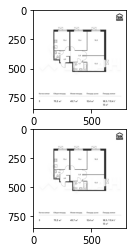

In [ ]:
import matplotlib.pyplot as plt
def draw_with_boxes(image: np.ndarray,
                    preds: Dict[str, np.ndarray] = None,
                    conf_threshold=0.5) -> np.ndarray:

    image = image.copy()

    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    font_scale = 0.7
    line_type = 1
    label_padding = 5

    num_boxes = len(preds['boxes'])

    for i in range(num_boxes):
        if preds['scores'][i] < conf_threshold:
            continue
        x_min, y_min, x_max, y_max = preds['boxes'][i]

        cv2.rectangle(img=image,
                      pt1=(int(x_min), int(y_min)),
                      pt2=(int(x_max), int(y_max)),
                      color=(0, 0, 255),
                      thickness=-1)

    return image

##Загрузка тестового изображения
image = cv2.imread(f"{os.environ['HOME']}/train/test.png").astype(np.float32) / 255

## Вывод исходного изображения
plt.subplot(211)
im1 = plt.imshow(image)

## Применение модели
class_ids = config['data']['class_ids']
reverse_classes_map = {v: k for k, v in class_ids.items()}
bytearray_ = np.asarray(bytearray(image), dtype=np.uint8)
x = image
transform = ToTensorV2()
model = initialize_model(1 + max(config['data']['class_ids'].values()),
                             config['model']['image_size'], config['model']['image_size'], [0, 0, 0], [1, 1, 1],
                             config['training']['device'])
model.load_state_dict(torch.load("./model_obj_2"))
x = transform(image=x)['image']
with torch.no_grad():
  y_pred = model.eval()([torch.tensor(x, device=config['training']['device'])])[0]
  y_pred = {key: y_pred[key].cpu().numpy() for key in y_pred}
  y_pred['labels'] = np.array([reverse_classes_map[label] for label in y_pred['labels']])

  x = torch.moveaxis(x, 0, -1).cpu().numpy()
  x = np.ascontiguousarray(255 * x, dtype=np.uint8)

image_with_boxes = draw_with_boxes(x, y_pred)

## Вывод реузультирующего изображения
plt.subplot(212)
im1 = plt.imshow(image_with_boxes)
